<a href="https://colab.research.google.com/github/lzeng11bc/DNNWithTensorflow/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 16 Natural Language Processing with RNNs and Attention


## Generating Shakespearean Text Using a Character RNN
### Creating the Training Dataset
* **First, let's download all of Shakespeare's work, using Kera's handy** get\_file( ) **function and downloading the data from** Char-RNN project

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


* **Next, we must encode every character as an integer. One option is to create a custom preprocessing layer.**
* **In this case, it will be simpler to use Kera's** Tokenizer **class.**
    * **First we need to fit a tokenizer to the text: it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters(it does not start at 0, so we can use that value for masking)**

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

* **We set** char\_level=True **to get character-level encoding rather than the default world-level encoding**
* **This tokenizer converts the text to lowercase by default(but you can set** lower=False **if you do not want that)**
* **Now the tokenizer can encode a sentence(or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text**

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

**Let's encode the full text so each character is represented by its ID(we subtract 1 to get IDs from 0 to 38, rather than 1 to 39):**

In [ ]:
import numpy as np

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [ ]:
encoded

array([19,  5,  8, ..., 20, 26, 10])

### How to Split a Sequential Dataset
* **When dealing with time series, you would generally split across time,: for example, you might take the years 2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set.**
* **So it is often safer to split across time-but this implicitly assumes that the patterns in the RNN can learn in the past(in the training set) will still exist in the future. In other words, we assume that the time series is *stationary*.**
    * **To make sure the time series is indeed sufficiently stationary, you can plot the model's errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough, and you might be better off training the model on a shorter time span.**

**For the shakespeare data, let's take the first 90% of the text for the training set(keeping the rest for the validation set and the test set), and create a** tf.data.Dataset **that will return each character on by one from this set**

In [ ]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### Chopping the Sequential Dataset into Multiple Windows
* **The training set now consists of a single sequence of over a million characters, so we can't just train the neural network on it: the RNN would be equivalent to  adeep net with over a million layers, adn we would have a single(very long) instance to train it.**
* **Instead, we will use the dataset's** window( ) **method to convert this long sequence of characters into many smaller windows of text**
* **Every instance in the dataset will be a fairly short substring of the whole text, and the RNN will be unrolled only over the length of these substrings. This is called *truncated backpropagation through time*.**


* **Let's call the** window( ) **method to create a dataset of short text windows**

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

* **You can try tunning n\_steps: it is easire to train RNNs on shorter input sequences, but of course the RNN will not be able to learn any pattern longer than n\_stpes, so don't make it too small.**
* **By default, the window( ) method creates nonoverlapping windows, but to get the largest possible training set we use** shift=1 **so that the first window contains character 0 to 100, the second contains characters 1 to 101. and so on.**
* **To ensure that all windows are exactly 101 characters long(which will allow us to create batches without having to do any padding), we set** drop\_remainder=True **(otherwise the last 100 windows will contain 100 characters, 99 characters and so on down to 1 character)**
* **The window( ) method creates a dataset that contains windows, each of which is also represented as dataset. It's a *nested dataset*, analogous to a list of lists.**
    * **This is useful when you want to transform each window by calling its dataset methods(e.g., to shuffle them or batch them).**
    * **However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets. So, we must call the** flat\_map( ) **method: it converts a nested dataset into a *flat dataset*(one that does not contain datasets).**
    * **Moreover, the** flat\_map( ) **method takes a function as an argument, which allows you to transform each datast in the nested dataset before falttening. For eacmple, if you pass the function** lambda ds: ds.batch(2) **to** flat\_map( ), **then it will transform the nested dataset** {{1, 2}, {3, 4, 5, 6}} **into the flat dataset** {{1, 2}, {3, 4}, {5, 6}}: **it's a dataset of tensor of size 2.**

**Flatten the dataset**

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

* **Notice that we call** batch(window\_length) **on each window: since all windows have exactly that length, we will get a single tensor for each of them. Now the dataset contains consecutive windows of 101 characters eeach.**
* **Since Gradient Descent works best when the instances in the training set are independent and identically distributed, we need to shuffle these windows. Then we can batch the windows and separate the inputs(the fist 100 characters) from the target(the last character).**

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

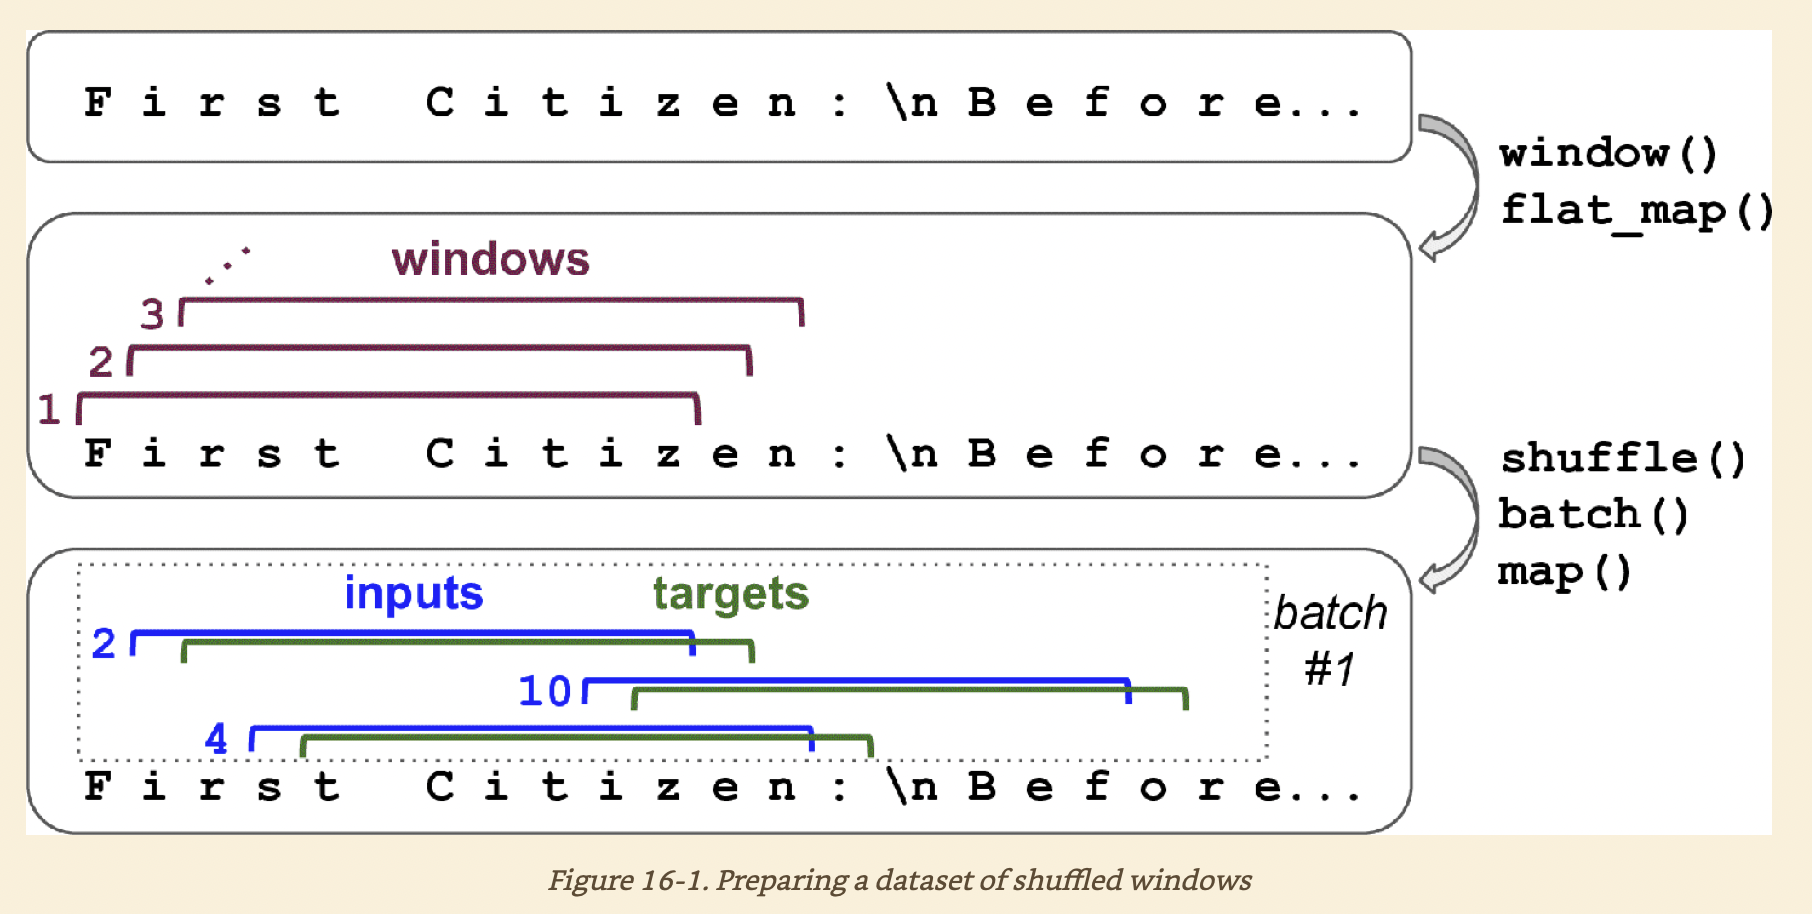

* **Categorical input features should generally be encoded, usually as one-hot vector or as embeddings.**
* **Here, we will encode each character using a one-hot vector becausse there are fairly few distinct characters.**

In [ ]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)

* **Finally, we just need to add prefetching**

In [ ]:
dataset = dataset.prefetch(1)

### Building and Training the Char-RNN Model
* **To predict the next character based on the previous 100 characters, we can use an RNN with 2 GRU layers of 128 units each and 20% dropout on both the inputs(dropout) and the hidden states(recurrent\_dropout).**
* **The output layer is a time-distributed Dense layer. This time this layer must have 39 units(max\_id) because there are 39 distinct characters in the text, and we want to output a probability for each possible character(at each time step).**
* **The output probabilities should sum up to 1 at each time step, so we apply the softmax activations function to the Dense layer.**
* **We can compile this model, using the "sparse\_categorical\_crossentropy" loss and an Adam optimizer**
* **Finally, we are ready to train the model for several epochs(this may take many hours, depending on the network).**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('gdrive/MyDrive')

In [ ]:
dirname = os.getcwd()

In [ ]:
dirname

'/content/gdrive/MyDrive'

In [ ]:
model = keras.models.load_model('my_shakespeare_model.h5')

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(dirname + "/my_shakespeare_model.h5")

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                                                  dropout=0.2, recurrent_dropout=0.2),
                                 keras.layers.GRU(128, return_sequences=True, 
                                                  dropout=0.2, recurrent_dropout=0.2),
                                 keras.layers.TimeDistributed(keras.layers.Dense(max_id, 
                                                                                 activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
history = model.fit(dataset, epochs=20, callbacks=[checkpoint_cb])

Epoch 1/20
  10313/Unknown - 2851s 276ms/step - loss: 1.3122

KeyboardInterrupt: ignored

### Using the Char-RNN Model
* **Now that we have a model that can predict the next character in text written by Shakespeare. To feed it some text, we first need to preprocess it like we did earlier, so let's create a function for this:**

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

**Let's use the model to predict the next letter in some text**

In [ ]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

### Generating Fakse Shakespearean Text
* **To generate new text using the Char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter, and so on.**
* **In practice, this often leads to the same wors being repeated over and over again. Instead, we can pick the next character randomly, with a probability equal to the estimated probability, using TensorFlow's** tf.random.categorical( ) **function. This will generate more diverse and interesting text.**
* **The** categorical() **function samples random calss indices, given the class log probabilites(logits). To have more control over the diversity of the generated text, we can divide the logits by a number called the *temperature*, which we can tweak as we wish: a temperature close to 0 will favor the high-probability characters, while a very high temperature will give all characters an equal probability**

* **The following** next\_char( ) **funciton uses this appraoch to pick the next character to add to the input text:**

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new[0, -1:, :])
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

* **Next, we can write a small function that will repeatedly call** next\_char( ) **to get the next character and append it to the given text**

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

* **We are now ready to generate some text. Let's try with some different temperatures**

In [ ]:
print(complete_text("t", temperature=0.2))

In [ ]:
print(complete_text("w", temperature=1))

In [ ]:
print(complete_text("w", temperature=2))

* **To generate more convinving text, you could try using more** GRU **layers and more neurons per layer, train for longer, and add some regularization.**
* **Moreover, the model is currently incapable of learning patterns longer than** n\_steps, **which is just 100 characters.**
* **You could try making this window larger, but it will also make training harder, and even LSTM and GRU cells cannot handle very long sequences.**
* **Alternatively, you could use a stateful RNN**

### Stateful RNN
* **Until now, we have used only *stateless RNNs*: at each training iteration the model starts with a diffent state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away, as it is not needed anymore.**
* **What if we told the RNN to preserve this final state after processing one training btcha and use it as the initial state for the next training batch? This way the model can learn long-term patterns despit only backpropagating through short sequences. This is called *stateful RNN*.**

##### How to build a Stateful RNN
* **A statful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off.**
    * **The first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences rather than the shuffles and overlapping sequences we used to train stateless RNNs)**
* **When creating the** Dataset,**we must therfore use** shift=n\_steps(**instead of** shift=1) **when calling the** window( ) **method.**
* **Moreover, we must obviouslu *not* call the** shuffle( ) **method. Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a stateless RNN. The simplest solution is to just use "batches" containing a single window.**

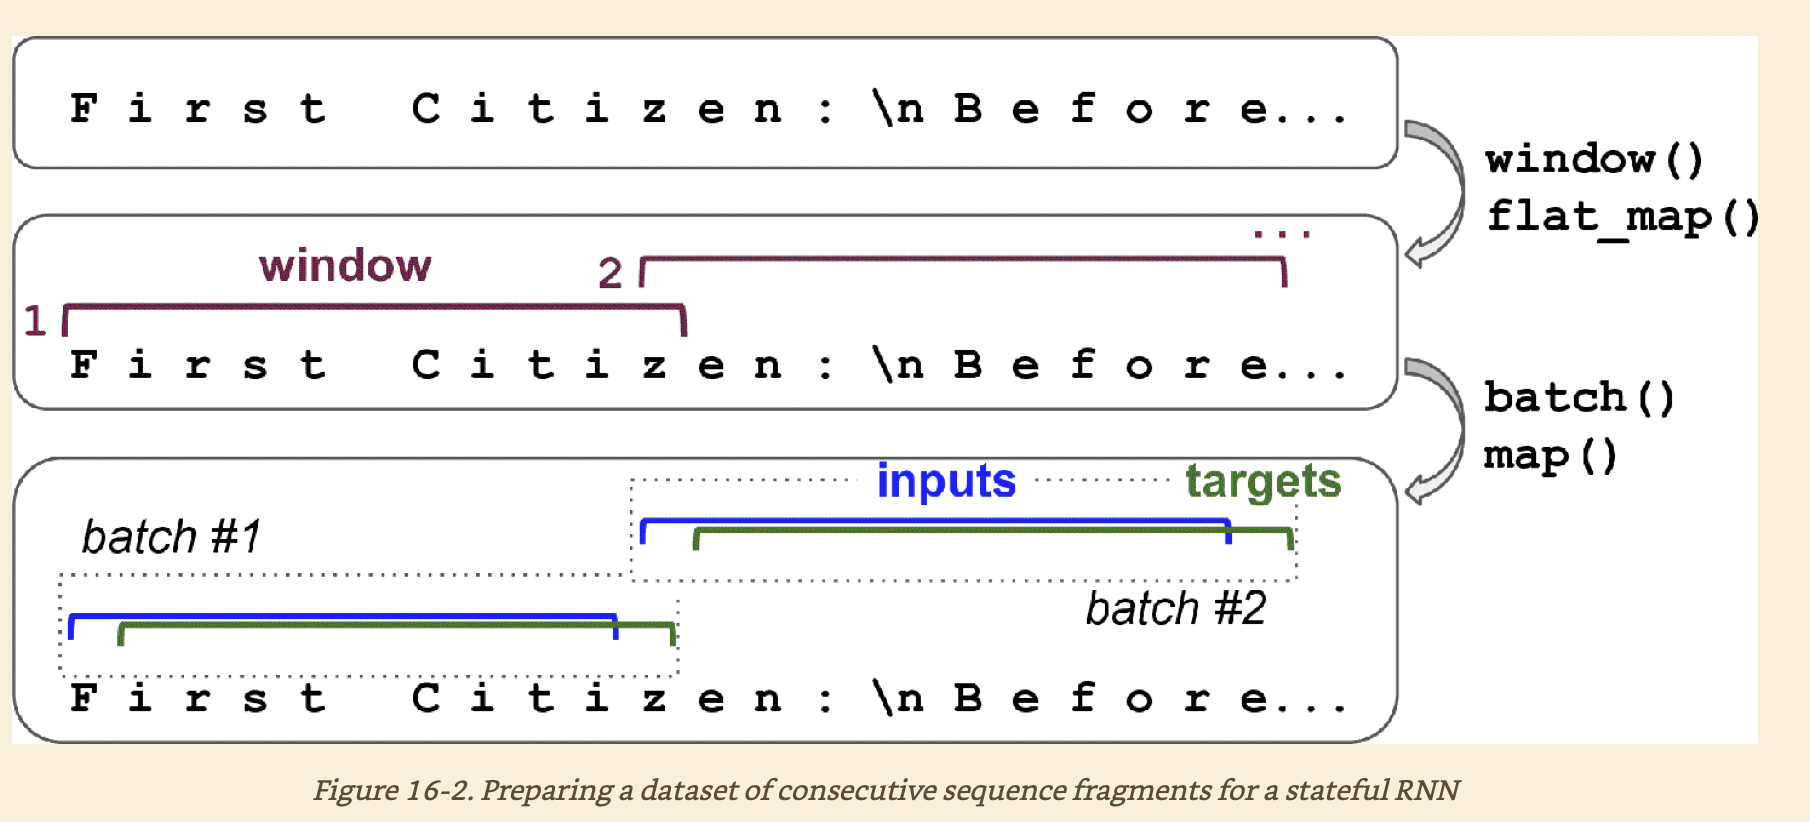

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)
dataset = dataset.prefetch(1)

* **Batching is harder. We could chop Shakespeare's text into 32 texts of equal length, create one dataset of consecutive input sequences for each of them, and fianlly use** tf.Dataset.zip(datasets).map(lamba \*windows: tf.stack(windows)) **to create proper consecutive bataches, where the nth input sequence in a batch starts off exactly where the nth input sequence ended in the previous batch.**

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

* **Now let's create the stateful RNN. First, we need to set** stateful=True *when creating every recurrent layer.**
* **Second, the stateful RNN needs to know the batch size(since it will preserve a state for each input sequence in the batch), so we must set the** batch\_input\__shape **argument in the first layer.**
    * **Note that we can leave the second dimension unspecified, since the inputs could have any length:**

In [ ]:
model = kears.models.Sequential([
                                 keras.layers.GRU(128, return_sequences=True, stateful=True,
                                                  dropout=0.2, recurrent_dropout=0.2,
                                                  batch_input_shape=[batch_size, None, max_id]),
                                 keras.layers.GRU(128, return_sequences=True, stateful=True,
                                                  dropout=0.2, recurrent_dropout=0.2),
                                 keras.layers.TimeDistributed(keras.layers.Dense(max_id, 
                                                                                 activation="softmax"))
])

* **At the end of each epoch, we need to reset the states before we go back to the beginning of the text. For this, we can use a small callback:**

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

* **Now we can compile and fit the model(for more epochs, because each epoch is much shrter than earlier, and there is only one instance per batch)**

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam")
model.fit(dataset, epochs, callbacks=[ResetStatesCallback()])

## Sentiment Analysis


* **If MNIST is the "hello world" of computer vision, then the IMDB reviews dataset is the "hello world" of natural language processing: it consists of 50,000 movie reviews in English(25,000 for training, 25,000 for testing) extracted from the famous Internet Movie Database.**
* **Use the functions provided by Keras to load it**

In [ ]:
  (X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

* **As you can see, the dataset is already preprocessed for you:** X\_train **consists of a list of reviews, each of which is represented as a NumPy array of integers, where each integer represents a word.**
* **All punctuation was removed, and the words were converted to lowercase, split by spaces, and fianlly indexedby frequency(so low integers correspond to frequent words).**
* **The integers 0, 1, and 2 are special: they represent padding token, the *state-of-sequence*(SSS) token, and unknown words, respectively.**

**To visulize a review, you can decide it like this:**

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}

In [ ]:
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token

" ".join([id_to_word[id_] for id_ in X_train[0][:20]])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you"

* **In a real project, you will have to preprocess the text yourself. You can do that using the same** Tokenizer **class we used earlier, but this time setting** char\_level = False(**which is the default**)
* **When encoding words, it filters out a lot of characters, including most punctuation, line breaks, and tabs(but you can change this by setting the** filters **argument). Most importantly, it uses spaces to identify word boundaries.**

* **Handle preprocessing using only TensorFlow operations, so it can be included in the model itself**

In [ ]:
import tensorflow_datasets as tfds
datasets, info = tfds.load('imdb_reviews', as_supervised=True,
                           with_info=True)
train_size = info.splits["train"].num_examples

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXBM4YP/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXBM4YP/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXBM4YP/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


* **Write the preprocessing function**

In [ ]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b"  ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

* **It starts by truncating the reviews, keeping only the first 300 characters of each: this will speed up training, and it won't impact performace too much because you can generally tell whether a review is positive or not in the first sentence or negative.**
* **Then it uses *regular expressions* to replace** \<br /\> **tags with spaces, and to replace any characters other than letters and quotes with spaces and to replace any characters other than letters and quotes with spaces.**
* **Finally the** preprocess( ) **fucntion splits the reviews by the spaces, which returns a ragged tensor, and it converts this ragged tensor to a dense tensor, padding all reviews with the pdding token** "\<pad\>" **so that they all have the same length.**

* **Next, we need to construct the vocabulary. THis requires going through the whole training set once, applying our** preprocess( ) **function, and using a** Counter **to count the number of occurences of each word.**

In [ ]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

**We can look at the most common words**

In [ ]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

**Since we don't need our model to know all the words in the dictioanry to get good performance, we can truncate the vocabulary to know only the 10,000 most common words**

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
                        word for word, count in vocabulary.most_common()[:vocab_size]
]

**Add a preprocessing step to replace each word with its ID(i.e., its index in the vocabulary)**
* **We can create a lookup table for this, using 1,000 out-of-vocabulary(oov) buckets**

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

**We can use this table to look up the IDs of a few words**

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

* **Sunce "this", "movie", and "was" were found in the table, so there IDs are lower than 10,000, while the word "faaaaantastic" was not found, so it was mapped to one of the oov buckers, with and ID greater than or equal to 10,0000**

* **Now we are ready to create the final training set. We batch the reviews, then convert them to short sequences of wors using the** preprocess() **function, then encode these words using a simple** encode\_words( ) **function that uses the table that we just built, and finaly prefetch the next batch**

In [ ]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

* **Finally we can create the model and train it**

In [ ]:
embed_size = 128
model = keras.models.Sequential([
                                 keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                                                        input_shape=[None]),
                                 keras.layers.GRU(128, return_sequences=True),
                                 keras.layers.GRU(128),
                                 keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 89s 110ms/step - loss: 0.6918 - accuracy: 0.5235
Epoch 2/5
782/782 [==============================] - 83s 106ms/step - loss: 0.6240 - accuracy: 0.6377
Epoch 3/5
782/782 [==============================] - 85s 108ms/step - loss: 0.4094 - accuracy: 0.8136
Epoch 4/5
782/782 [==============================] - 84s 108ms/step - loss: 0.3216 - accuracy: 0.8635
Epoch 5/5
782/782 [==============================] - 84s 107ms/step - loss: 0.2851 - accuracy: 0.8835


* **The first layer is an** Embedding **layer, which will convert word IDs into embeddings**
* **The embedding matrix needs to have one row per ID(** vocab\_size + num\_oov\_buckets **)and one column per word ID(this example uses 128 dimensions, but this is a hyperparameter you could tune)**.
* **The inputs of the model will be 2D tensors of shape** \[batch size, time steps\], **the output of the** Embedding **layer wiil be a 3D tensor of shape** \[batch size, time steps, embedding size\]
* **The rest of the model is composed of towo GRU layers, with the second one returning only the output of the last time step.**
* **The output layer is just a single neuron using the sigmoid actiavtion function to output the estimated probability that the review expresses a positive sentiment regarding the movie**

### Masking 
* **Simply add** mask\_zero=True **when creating the** Embediing **layer. This means that padding tokens(whose ID is 0) will be ignored by all downstream layers.**
* **The way this works it that the Embedding layer creates a mask tensor equal to** k.non\_equal(inputs, 0)(**where** K = keras.backend): **it is a Boolean tensor with the same shape as the inputs, and it is equal to** False **anywhere the wordIDs are 0, or** True **otherwise.**
* **This mask tensor is then automatically propagated by the model to all subsequent layers, as long as the time dimension is preserved.**
* **Each layer may handle the mask differently, but in general they simply ignored masked time steps(i.e., time stpes for which the mask is** False)
* **All layers that receive the mask must support masking(or else an exception will be raised). This includes all recurrent layers, as well as the** TimeDistributed **layer and a few other layers.**
    * **Any layer that supports masking must have a** supports\_masking **atrribute equal to** True.
    * **If you want to implement your own custom layer with masking support, you should add a** mask **argumentto the** call( ) **method(and obviosly make the method use the mask somehow). Additionally, you should set** self.supports\_masking = True **)in the constructor**.
    * **If your layer does not start with an** Embedding **layer, you may use the** keras.layers.Masking **layer instead: it sets the mask to** K.any(K.not\_equal(inputs, 0), axis = -1), **meaning that time steps where the last dimension is full of zeros will be masked out in subsequent layers**

* **Using masking layers and automatic mask propagation works best for simple** Sequential **models. It will not always work for more complex models, such as when you need to mix** conv1D **layers with recurrent layers. In such cases, you will need to explicitly compute the mask and pass it to the apprpriate layers, using either the Functional API or the Subclassing API.**

**The following model is identical to the previous model, except it is built using the Functional API and handles masking manually:**

In [ ]:
K = keras.backend
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.Model(inputs=[inputs], outputs=[outputs])

### Reusing Pretrained Embeddings
* **The TensorFLow Hub project maked it easy to reuse pretrained model compoenents in your own models. These model components are called *modules***.
* **Simply browse the TF Hub repository, find the one you need, and copy the code example in your projectm and the module will be automatically downloaded along with its pretrained weights, and included in your model.**

In [ ]:
import tensorflow_hub as hub
model = keras.Sequential([
                          hub.KerasLayer("http://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                                         dtype=tf.string, input_shape=[], output_shape=[50]),
                          keras.layers.Dense(128, activation="relu"),
                          keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

* **The** hub.KerasLayer **layer downloads the module from the given URL. THis particular module is a *sentence encoder*: it takes strings as input and encodes each one as a single vector(in this case, a 50-dimensional vector)**
* **Internally, it parses the string(splitting wors on space) and embeds eahc word using an embedding matrix that was pretrained on a huge corpus**
* **We can add two simple** Dense **layers to create a good sentiment analysis model. By default, a** hub.KerasLayer **is not trainable, but you can set** trainable=True **when creating it to change that so you can fine-tune it for your task**

* **Next, we can just load the IMDB reviews dataset - no need to preprocess it(except for batching and prefecthing)- and directly train the model**

In [ ]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5868 - accuracy: 0.6901
Epoch 2/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5188 - accuracy: 0.7428
Epoch 3/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5122 - accuracy: 0.7468
Epoch 4/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5080 - accuracy: 0.7509
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5048 - accuracy: 0.7521


* **By default, TF Hub will cache the downloaded files into the local system's temporary directory. You may prefer to download them into a more permanent directory to avoid having to download them again after every system cleanup.**
    * **To do that , set the** TFHUB\_CACHE\_DIR **environment variable to the directory of your choice(e.g.,** os.enciron\["TFHUB\_CACHE\_DIR"\] = "./my\_tfhub\_cache")

## An Encoder-Decoder Network for Neural Machine Translation

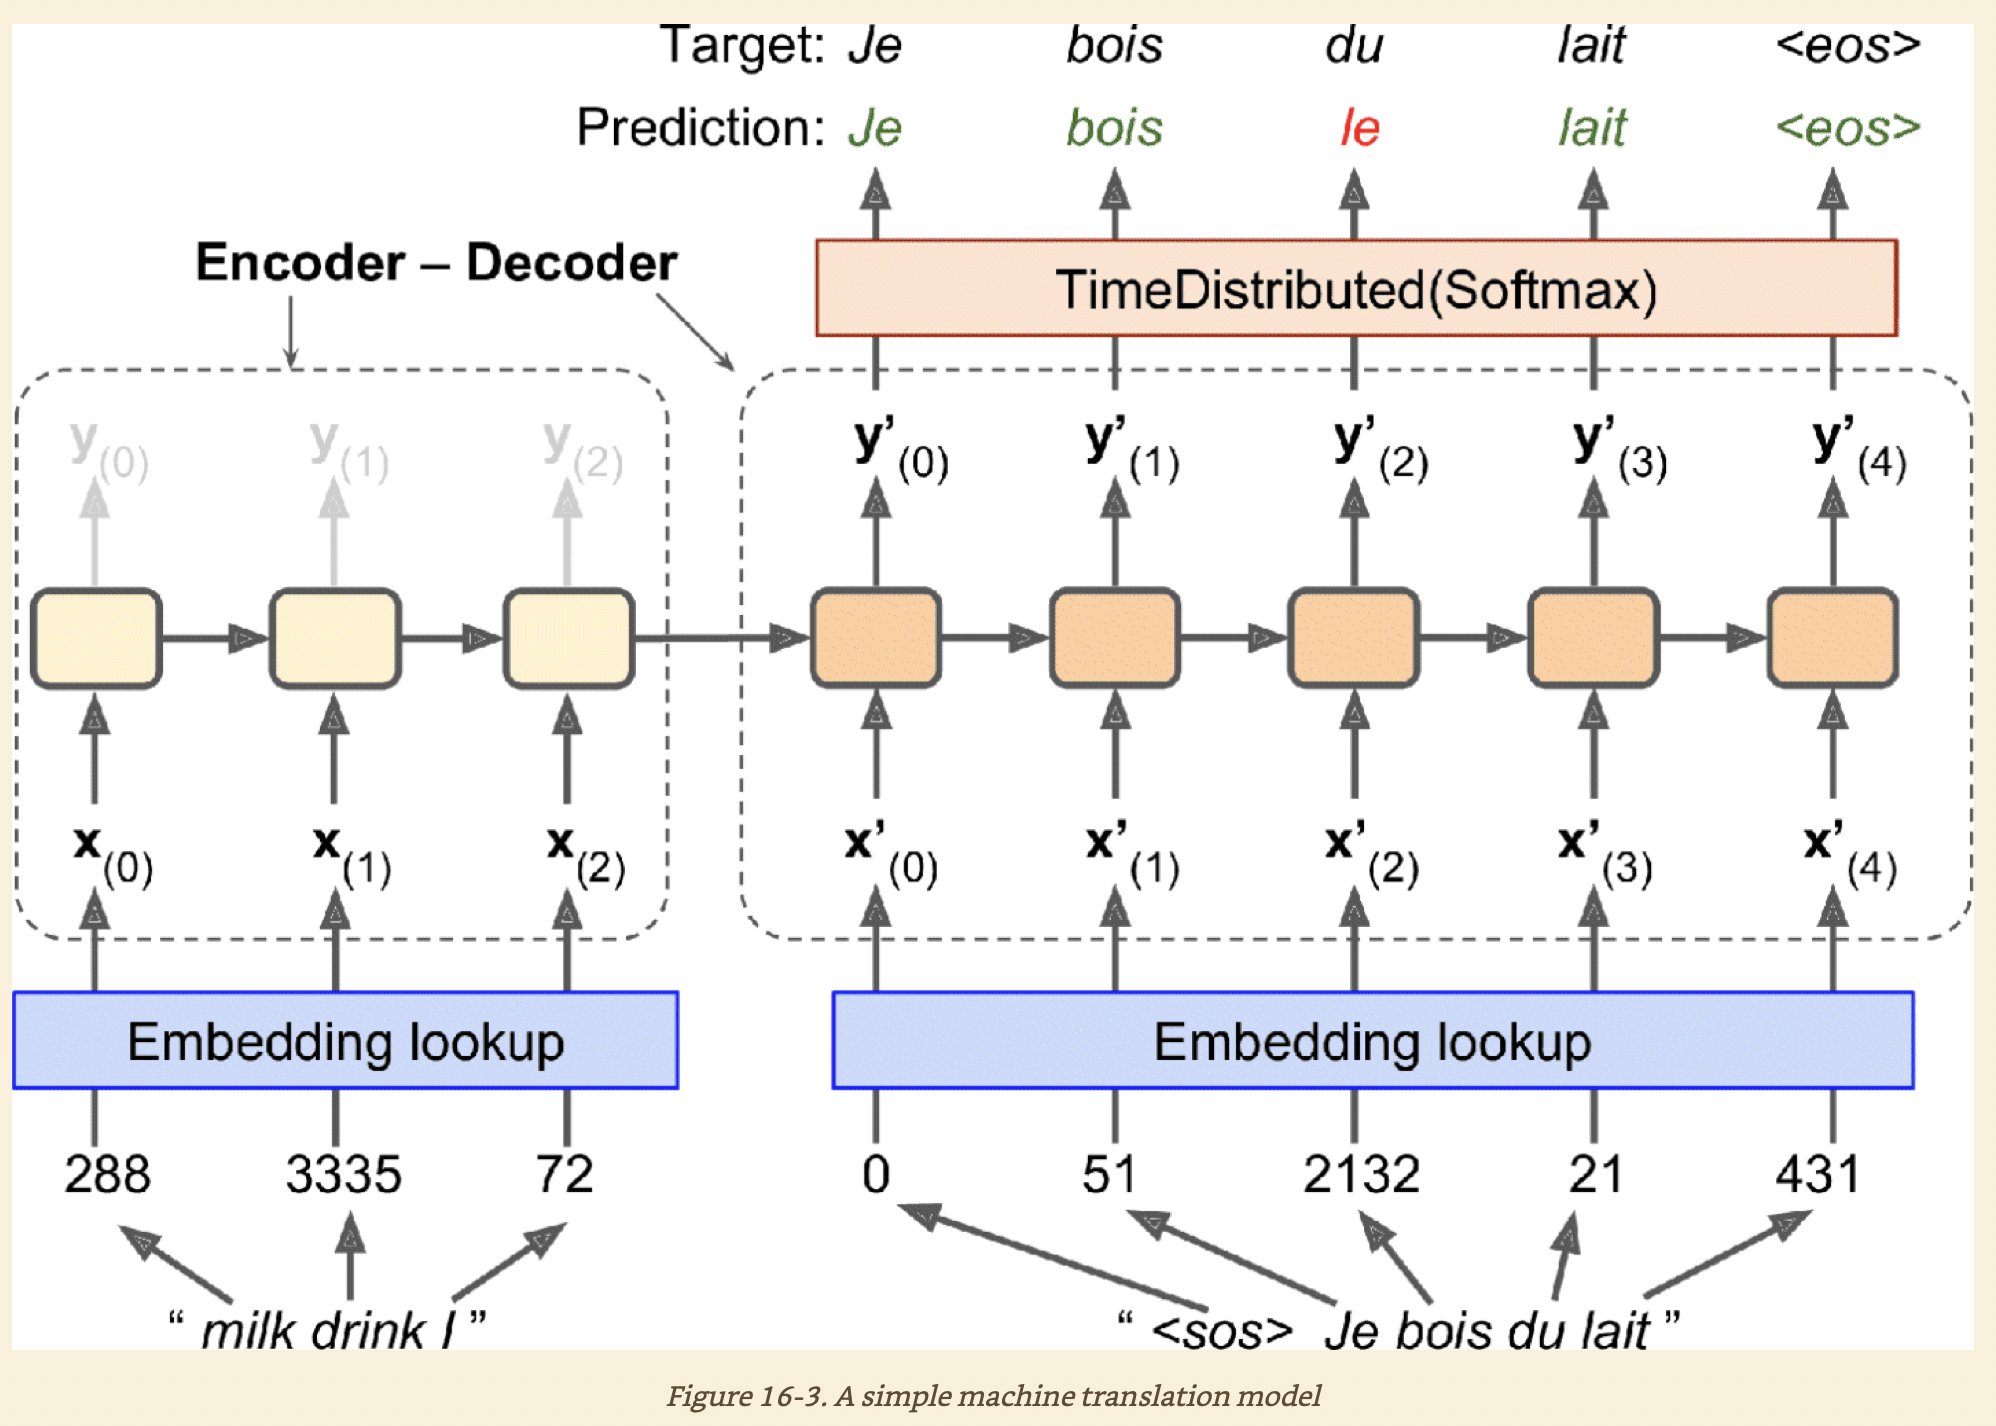

* **The english sentences are fed to the encoder, and the decoder outputs the French translations**
* **The French translations are also used as inputs to the decoder, but shifted back by one step. In other words, the decoder is given as input the word that is *should* have output at the previous step(regardless of what it actually otuput_.**
* **For the very first word, it is given the** start-of-sequence(SOS) **token. The decoder is expected to end the sentence with an end-of-sequence(EOS) token.**
* **Note that the English sentences are reversed before they are fed to the encoder. This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that's generally the first thing that the decoder needs to translate**
* **Each word is initially represented by its ID. Next, an** embedding **layer returns the word embedding. These word embeddings are what is actually fed to the encoder and the decoder.**
* **At each step, the decoder outputs a score for each word in the output vocabulary(i.e., French), and the softmax layer turns these scores into probabilities. The word with the highest probability is output.**
* **This is very much like a regular classification task, so you can train the model using the** "sparse\_categorical\_crossentropy" **loss.**

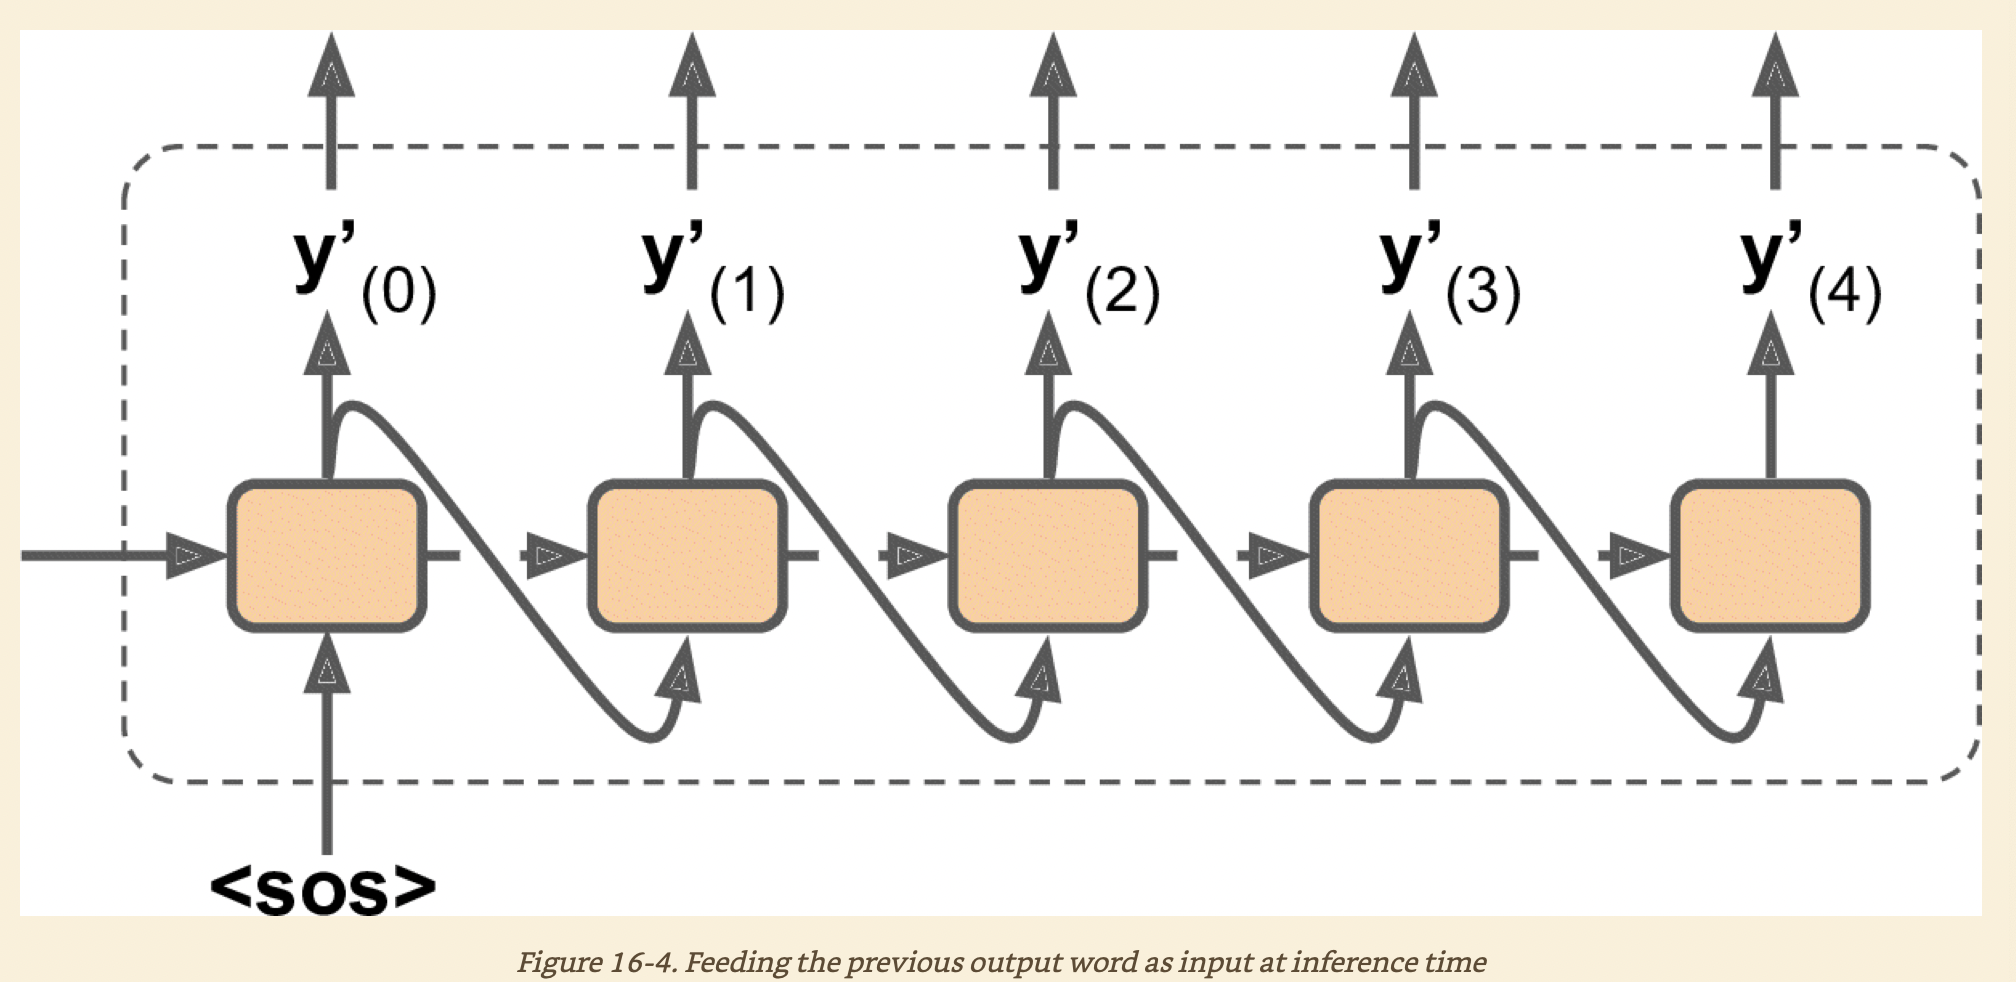

* **Note that at inference time(after training), you will not have the target sentence to feed the decoder.Instead, simply feed the decoder the word that it output at the previous step.(This will require an embedding lookup)**

**There are a few more detaisl to handle to implement this model**
* **For a sentence lengths that vary, group sentences into buckets of similar lengths(e.g., a bucket fot the 1 to 6-word sentences, another for the 7- to 12- word setences, and son on), using padding for the shorter sequences to ensure all sentences in a bucket have the same lenght.**
* **We want to ignore any output past the EOS token, so those tokens should not contribute to the loss(they must be masked out).**
* **When the output vocabulary is large, outputting a probability for each and every possible word would be terribly slow. To avoid this, one solution is to look only at the logits output by the model for the correct word and for a random sample of incorrect words, then compute and approximation of the loss based only on these logits.**
    * **In TensorFlow, you can use the** tf.nn.sampled\_softmax\_loss( ) **function for this during training and use the normal softmax function at inference**

* **The following code creates a basic Encoder-Decoder model.**

In [30]:
pip install tensorflow_addons

     |████████████████████████████████| 706kB 5.9MB/s 


In [33]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths
)

Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
                    outputs=[Y_proba])

* **First, we set** return\_state=True **when creating the** LSTM **layer so that we can get its final hidden state and pass it to the decoder**
* **The** TraininingSampler **is one of several samplers availiable in TensorFlow Addons: their role is to tell the decoder at each step what it shoudl pretend the previous output was.**
    * **During inference, this should be the mebedding of the token that was actually output.**
    * **During training, it should be the embedding of the previous target token: this is why we used the** TrainingSampler**
* **In practice, it is oft`en a good idea to start training with the embedding of the target of the previous time step and gradually transition to using the embedding of the actual token that was output at the previous step.**
* **The** ScheduledEmbeddingTrainingSampler **will randomly choose between the target of the actual output, with a probability that you can gradually change during trainning.**

## Bidirectional RNNs
* **At each time step, a regular recurrent layer only looks at past and present inputs before generating its output.**
* **For many NLP tasks, such as Neural Machine Translation, it is often preferable to look ahead at the next words before encoding a given word.**
    * **To implement this, run two recurrent layers on the same inputs, one reading the words from left to right and the other reding them from right to left. Then simply combine their outputs at each time step, typically by concatenating them. This is called a *bidirectional recurrent layer**
* **To implement a bidirectional recurrent layer in Keras, wrap a recurrent layer in a** keras.layers.Bidirectional **layer.**

In [ ]:
keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))

* **The** Bidirectional **layer will create a clone of the** GRU **layer(but in the reverse direction), and it will run both and concatenate their outputs.**
* **Although the** GRU **layer has 10 units, the** Bidirectional **layer will output 20 valhues per time step**

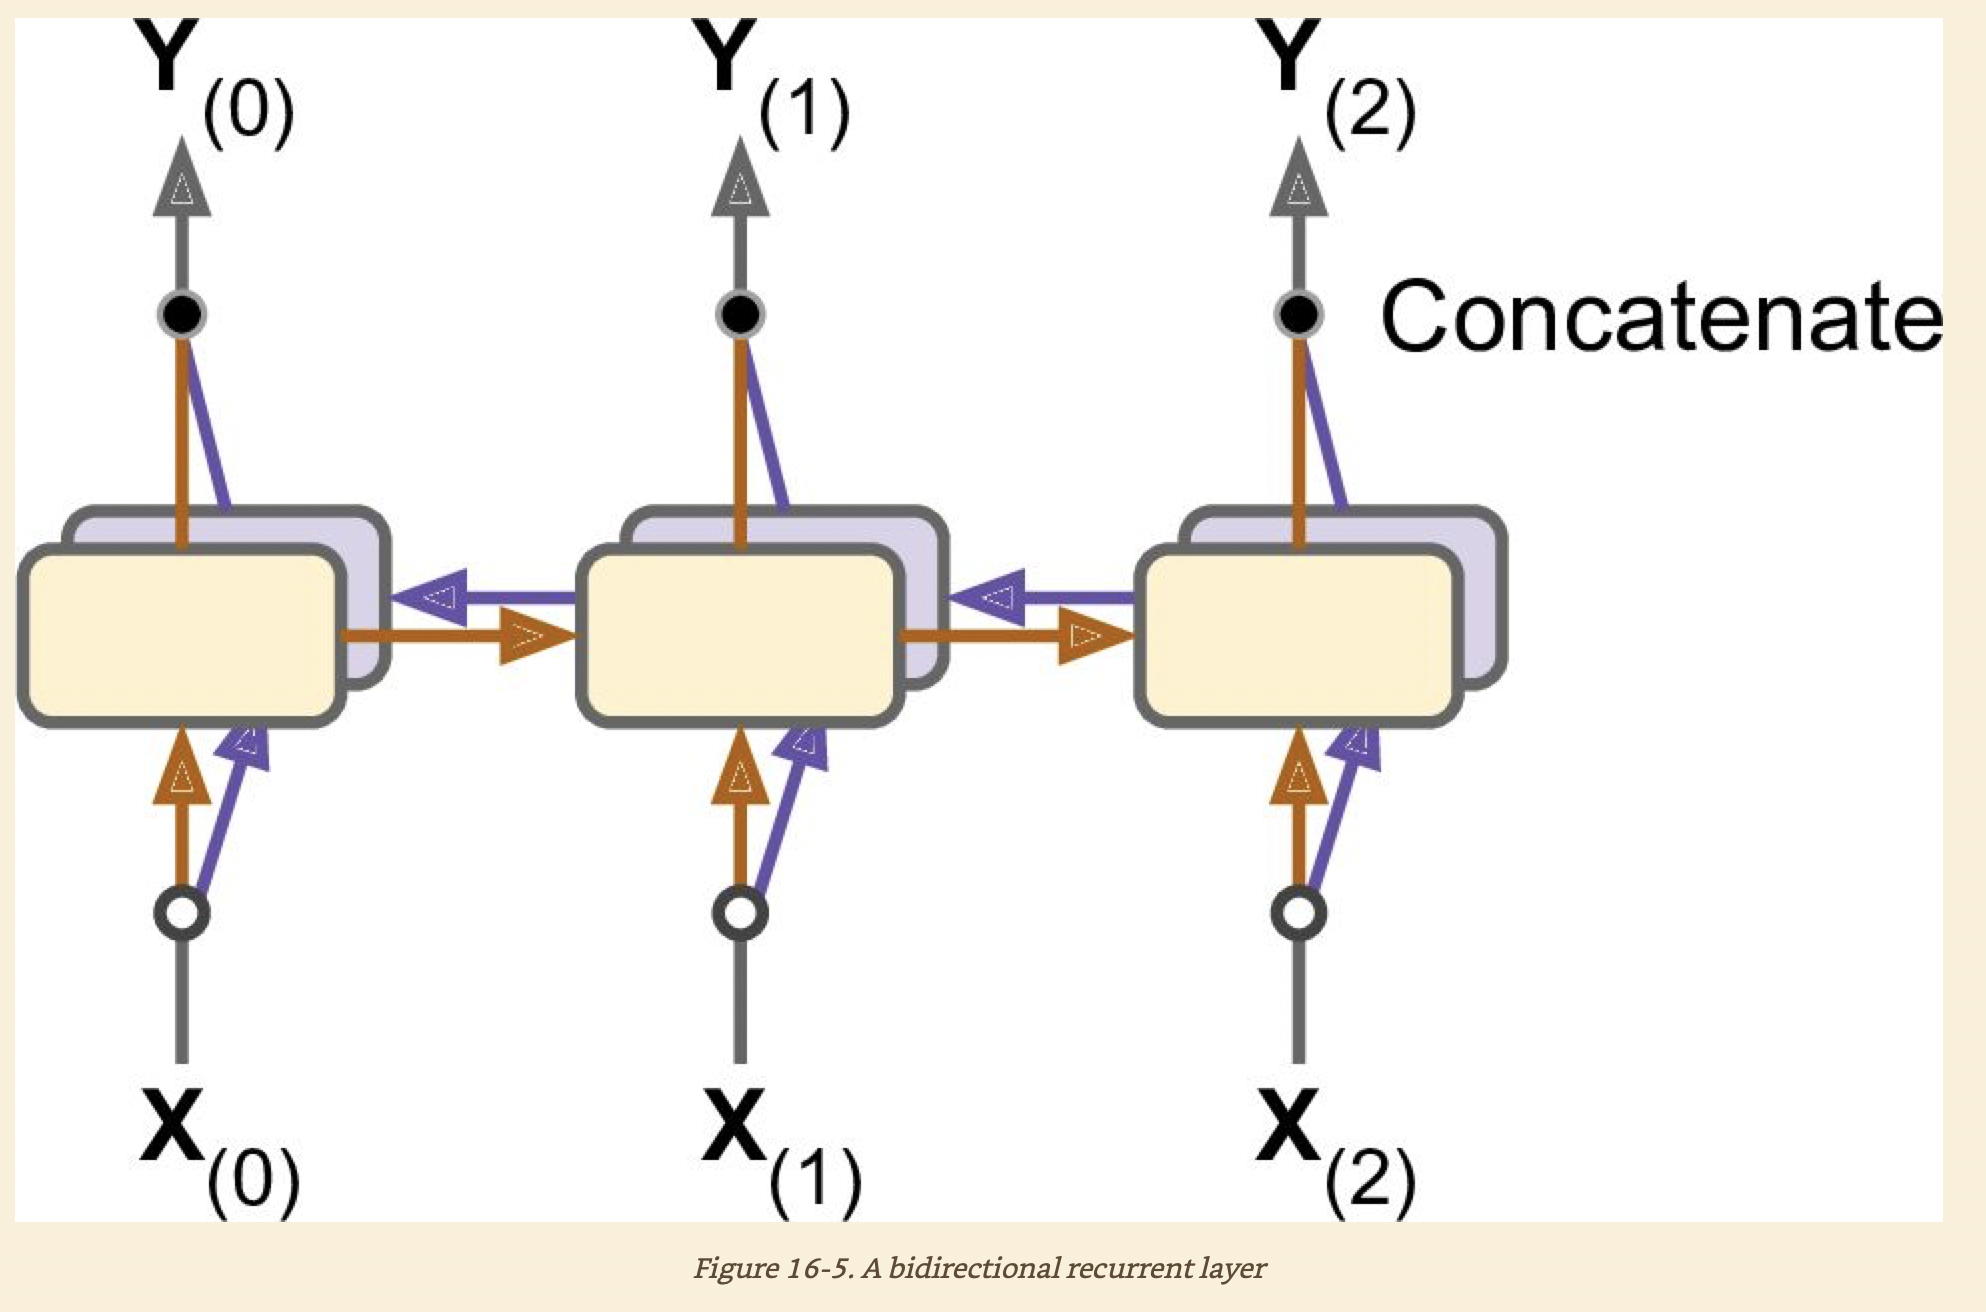

### Beam Search
* **It keeps track of a short list of the *k* most promising sentences, and at each decoder step it tries to extends them by one word, keeping only the *k* most likely sentences.**
    * **The parameter *k* is called the *beam width*.**